In [ ]:
!pip install pandas spacy networkx
!python -m spacy download en_core_web_sm


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:

import pandas as pd
import spacy
import networkx as nx

csv_file_path = 'TEST.csv'

# Load Spacy's NLP model
nlp = spacy.load("en_core_web_sm")

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)
df['Text'].dtypes
df['Text'] = df['Text'].astype(str)

# Initialize our graph
G = nx.Graph()

# Function to process text and add to graph
def add_to_graph(text, label, graph):
    # Use Spacy to find entities
    doc = nlp(text)
    for ent in doc.ents:
        # Add the entity as a node if it doesn't already exist
        if not graph.has_node(ent.text):
            graph.add_node(ent.text, type=ent.label_, label=label)
        # Now, create edges between all entities found in the same text snippet
        for ent2 in doc.ents:
            if ent != ent2:
                graph.add_edge(ent.text, ent2.text)

# Process each row of the DataFrame and add it to the graph
for index, row in df.iterrows():
    add_to_graph(row['Text'], row['Label'], G)

# At this point, the graph G has been constructed with entities as nodes and the co-occurrences as edges
# Further analysis can now be performed on the graph
# For demonstration purposes, we'll just print out the nodes

for node in G.nodes(data=True):
    print(node)  # Prints the node and its attributes


# 新段落

In [ ]:
import networkx as nx

# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)
# Print the node with the highest degree centrality
max_degree = max(degree_centrality, key=degree_centrality.get)
print(f"Node with highest degree centrality: {max_degree}")

# Identify communities using the Clauset-Newman-Moore greedy modularity maximization
from networkx.algorithms.community import greedy_modularity_communities
communities = list(greedy_modularity_communities(G))
print(f"Number of communities found: {len(communities)}")

# Let's inspect the first community
first_community = communities[0]
print(f"First community: {first_community}")

# For nodes, you might want to see the 'type' and 'label' attributes
for node in first_community:
    data = G.nodes[node]
    print(f"Entity: {node}, Type: {data.get('type')}, Label: {data.get('label')}")

# Save the graph if you haven't already
nx.write_graphml(G, 'knowledge_graph.graphml')

# Note: The above community detection is just one method; there are various methods available
# depending on the structure of your graph and the type of insights you're looking to derive.


In [ ]:
degree_centrality = nx.degree_centrality(G)
density = nx.density(G)

# Community detection (using the Clauset-Newman-Moore method)
from networkx.algorithms.community import greedy_modularity_communities

# Print out some of the calculated values
print(f"Graph density: {density:.4f}")
print(f"Number of communities detected: {len(communities)}")

# Inspect the largest centrality values
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)
for node, centrality in sorted_degree_centrality[:10]:
    print(f"Node: {node}, Degree Centrality: {centrality:.4f}")

Graph density: 0.0085
Number of communities detected: 40
Node: first, Degree Centrality: 0.5844
Node: Trump, Degree Centrality: 0.4784
Node: one, Degree Centrality: 0.4706
Node: GOP, Degree Centrality: 0.4389
Node: American, Degree Centrality: 0.3851
Node: Joe, Degree Centrality: 0.3665
Node: Americans, Degree Centrality: 0.3643
Node: the United States, Degree Centrality: 0.3545
Node: ISIS, Degree Centrality: 0.3507
Node: All Things Sean Hannity, Degree Centrality: 0.3507


In [ ]:
import networkx as nx

# Instantiate a new Graph object (replace this with nx.read_graphml('your_file.graphml') to read your graph)
G = nx.read_graphml('knowledge_graph.graphml')

# Add some nodes and edges with attributes for demonstration
G.add_node(1, time='5pm', label='user1')
G.add_node(2, time='6pm', label='user2')
G.add_edge(1, 2, weight=4.7)

# Basic Information about the Graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
is_directed = G.is_directed()

# Node and Edge Data
nodes_data = list(G.nodes(data=True))
edges_data = list(G.edges(data=True))

# Graph Properties
components = nx.number_connected_components(G) if not is_directed else None
degree_centrality = nx.degree_centrality(G)

# Graph Analysis
density = nx.density(G)

# Attributes and Schemas
node_time = G.nodes[1]['time']  # Accessing a node attribute

# Print the results
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Is the graph directed: {is_directed}")
print(f"Number of connected components: {components}")
print(f"Degree centrality: {degree_centrality}")
print(f"Graph density: {density}")
print(f"Attribute of node 1: {node_time}")

# To run community detection or other complex analyses, you would use specialized functions from networkx or other libraries.



In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv("Annotated_TEST.csv", nrows=100)

# Remove rows with missing values in the 'Text' column
df = df.dropna(subset=['Text'])

# Split data into training and evaluation sets (85% for training, 15% for evaluation)
train_df, eval_df = train_test_split(df, test_size=0.15, random_state=42)

# Tokenize text for both training and evaluation data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encoded_data = tokenizer(train_df['Text'].tolist(), padding=True, truncation=True, return_tensors='pt')
eval_encoded_data = tokenizer(eval_df['Text'].tolist(), padding=True, truncation=True, return_tensors='pt')

# Encode labels for both training and evaluation data
label_encoder = LabelEncoder()
train_df['Intention'] = label_encoder.fit_transform(train_df['Intention'])
eval_df['Intention'] = label_encoder.transform(eval_df['Intention'])

train_labels = torch.tensor(train_df['Intention'].tolist())
eval_labels = torch.tensor(eval_df['Intention'].tolist())

# Define datasets
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encoded_data, train_labels)
eval_dataset = CustomDataset(eval_encoded_data, eval_labels)

# Define DataLoader for both training and evaluation sets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=8, shuffle=False)

# Load pre-trained BERT model
num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

# Fine-tune BERT model
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Evaluate model
model.eval()

all_labels = []
all_predictions = []
for batch in eval_loader:
    with torch.no_grad():
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)
        all_labels.extend(labels.numpy())
        all_predictions.extend(predictions.numpy())

accuracy = accuracy_score(all_labels, all_predictions)
classification_rep = classification_report(all_labels, all_predictions)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_rep)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-2-563d729eb231>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-2-563d729eb231>:40: UserWarning: To copy construct from a tensor, it is re

Accuracy: 0.6666666666666666
Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        10
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         3

    accuracy                           0.67        15
   macro avg       0.22      0.33      0.27        15
weighted avg       0.44      0.67      0.53        15



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

file_path = 'TEST.csv'

# Read the data and extract text
texts = []
with open(file_path, 'r') as csv_file:
    csv_reader = csv.reader(csv_file)
    for row in csv_reader:
        texts.append(row[1])

# Vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(texts)

# Topic Modeling using LDA
num_topics = 20
lda_model = LatentDirichletAllocation(n_components=num_topics, max_iter=10, learning_method='online', random_state=42)
lda_model.fit(tfidf_matrix)

# Print the top words for each topic
print("Top words for each topic:")
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Topic {topic_idx+1}:")
    top_words_idx = topic.argsort()[:-10-1:-1]  # Top words for each topic
    top_words = [feature_names[i] for i in top_words_idx]
    print(", ".join(top_words))


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
# Load the CSV file with the appropriate encoding
df = pd.read_csv("Annotated_TEST.csv", encoding='latin1')


In [ ]:
# !pip install pandas plotly
import plotly.express as px
# Count the frequency of each intention
intention_counts = df['Intention'].value_counts()

# Create a sunburst chart
fig = px.sunburst(
    names=intention_counts.index,
    parents=['' for _ in intention_counts.index],
    values=intention_counts.values
)

# Update layout for better visualization
fig.update_layout(
    title="Intention Sunburst Chart",
    title_font_size=24,
    title_x=0.5,
    title_y=0.95,
    margin=dict(t=50, l=0, r=0, b=0),
    font=dict(size=14),
)

# Show the plot
fig.show()

In [ ]:
import pandas as pd
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

# Define stop words
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stop words and punctuation
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return tokens

# Count the frequency of words for each type
word_counts = {}
for intention in df['Intention'].unique():
    intention_df = df[df['Intention'] == intention]
    intention_text = intention_df['Text'].str.cat(sep=' ')
    intention_words = preprocess_text(intention_text)
    word_counts[intention] = Counter(intention_words)

# Select top 10 frequent words for each type
top_words = {}
for intention, counts in word_counts.items():
    top_words[intention] = dict(counts.most_common(7))

# Get all unique words
all_words = set()
for intention, words in top_words.items():
    all_words.update(words.keys())

# Organize data in the required format
data = {}
for word in all_words:
    data[word] = {}
    for intention, words in top_words.items():
        data[word][intention] = words.get(word, 0)

print(data)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


{'new': {'Media and Advocacy': 1013, 'Undetermined': 164, 'Politics Stances': 0, nan: 0, 'Conspiracy Theories': 0}, 'people': {'Media and Advocacy': 709, 'Undetermined': 155, 'Politics Stances': 749, nan: 0, 'Conspiracy Theories': 0}, 'would': {'Media and Advocacy': 0, 'Undetermined': 134, 'Politics Stances': 0, nan: 0, 'Conspiracy Theories': 0}, 'blasts': {'Media and Advocacy': 710, 'Undetermined': 0, 'Politics Stances': 0, nan: 0, 'Conspiracy Theories': 0}, 'change': {'Media and Advocacy': 1426, 'Undetermined': 292, 'Politics Stances': 1182, nan: 0, 'Conspiracy Theories': 0}, 'scheme': {'Media and Advocacy': 0, 'Undetermined': 0, 'Politics Stances': 0, nan: 0, 'Conspiracy Theories': 8}, 'green': {'Media and Advocacy': 0, 'Undetermined': 0, 'Politics Stances': 0, nan: 0, 'Conspiracy Theories': 5}, 'biden': {'Media and Advocacy': 0, 'Undetermined': 0, 'Politics Stances': 1736, nan: 0, 'Conspiracy Theories': 0}, 'market': {'Media and Advocacy': 0, 'Undetermined': 0, 'Politics Stances': 

<ipython-input-62-b3361d11383d>:21: DeprecationWarning:

`interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`


<ipython-input-62-b3361d11383d>:24: DeprecationWarning:

        `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

        In new code, for regular grids use `RegularGridInterpolator` instead.
      

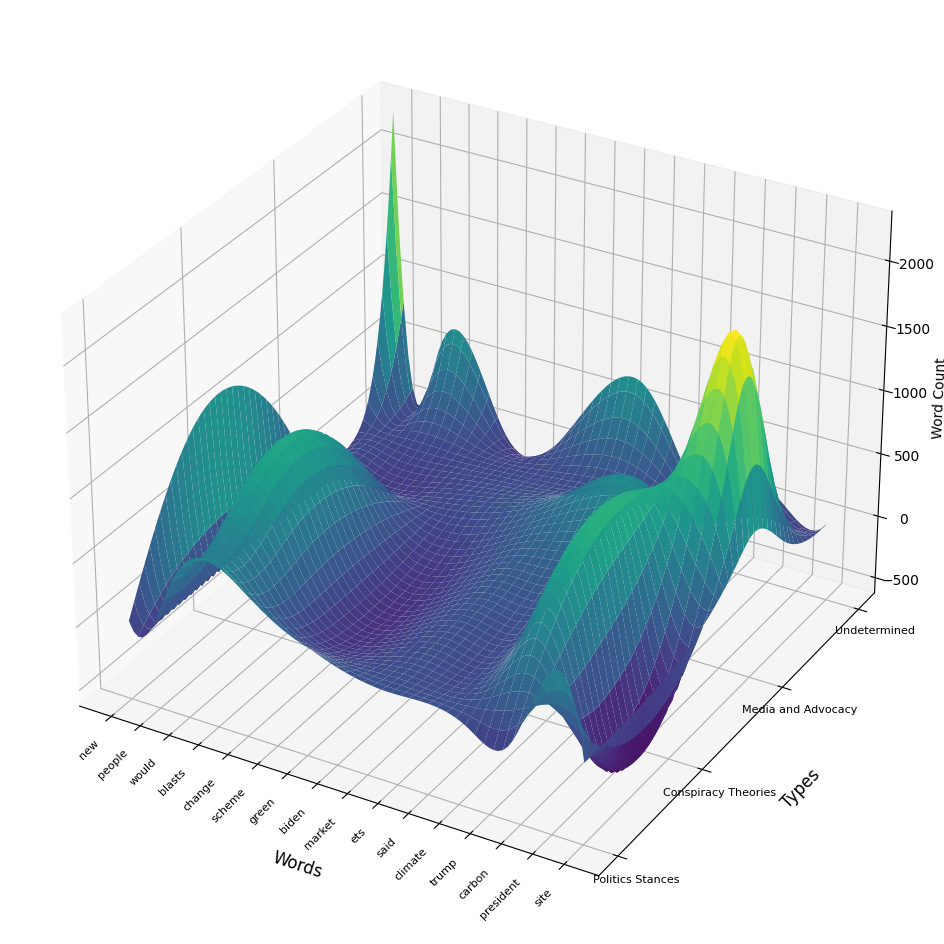

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Extracting data
words = list(data.keys())
types = ["Politics Stances", "Conspiracy Theories", "Media and Advocacy", "Undetermined"]
word_count = np.array([[data[word][type_] for type_ in types] for word in words])

# Create 3D plot
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

# Create denser meshgrid
x = np.arange(len(words))
y = np.arange(len(types))
x, y = np.meshgrid(x, y)

# Interpolate word_count values for the denser grid
from scipy.interpolate import interp2d
f = interp2d(x, y, word_count, kind='cubic')
x_new = np.linspace(0, len(words) - 1, 100)
y_new = np.linspace(0, len(types) - 1, 100)
word_count_interp = f(x_new, y_new)

# Plot surface
x_new, y_new = np.meshgrid(x_new, y_new)
ax.plot_surface(x_new, y_new, word_count_interp, cmap='viridis')

# Set labels
ax.set_xticks(np.arange(len(words)))
ax.set_xticklabels(words, rotation=45, ha='right', fontsize=8)
ax.set_yticks(np.arange(len(types)))
ax.set_yticklabels(types, fontsize=8)

ax.set_xlabel('Words', fontsize=12, labelpad=18)
ax.set_ylabel('Types', fontsize=12, labelpad=18)
ax.set_zlabel('Word Count', fontsize=10)

plt.show()
